In [1]:
import sys
from os.path import join as oj
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.append('../src')
import numpy as np
import data_pecarn, data_psrc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from validate import calc_stats

%matplotlib inline
%load_ext autoreload
%autoreload 2

d = data_pecarn.get_data(use_processed=True, dummy=True, frac_missing_allowed=1, impute_feats=False)
iaii = d['iai_intervention']
iai = d['iai']
fast_study_cohort, fast_abnormal = data_pecarn.get_FAST(d)    

![](../docs/ultrasound.png)

# Performance of FAST exam in isolation

In [8]:
print(f'{d.shape[0]} total patients ({iaii.sum()} IAI-I, {iai.sum()} IAI)', )
print(f'{fast_study_cohort.sum()} patients with valid FAST ({iaii[fast_study_cohort].sum()} IAI-I, {iai[fast_study_cohort].sum()} IAI)')
print(f'\tOf these {fast_study_cohort.sum()} patients, {fast_abnormal.sum()} have an abnormal scan')
print(f'\t\ttOf these {fast_abnormal.sum()} patients, {iaii[fast_abnormal].sum()} have IAI-I')
print(f'\tThis 26 is very low, we probably cant do much here but lets try...')

12044 total patients (203 IAI-I, 761 IAI)
837 patients with valid FAST (30 IAI-I, 65 IAI)
	Of these 837 patients, 26 have an abnormal scan
		tOf these 26 patients, 12 have IAI-I
	This 26 is very low, we probably cant do much here but lets try...


In [9]:
print('If we use FAST alone to detect IAI-I, we get the following results:')
# print('assume no interpretation means negative')
tn, fp, fn, tp, sens, spec = calc_stats(iaii[fast_study_cohort],
                                  fast_abnormal[fast_study_cohort])
print(f'\tSensitivity={sens:0.2f}')
print(f'\tSpecificity={spec:0.2f}')
print(f'\t----------------')
print(f'\t{tp=} {fp=}')
print(f'\t{fn=} {tn=}')

If we use FAST alone to detect IAI-I, we get the following results:
	Sensitivity=0.40
	Specificity=0.98
	----------------
	tp=12 fp=14
	fn=18 tn=793


In [10]:
print('If we use FAST alone to detect IAI, we get the following results:')
# print('assume no interpretation means negative')
tn, fp, fn, tp, sens, spec = calc_stats(iai[fast_study_cohort],
                                  fast_abnormal[fast_study_cohort])
print(f'\tSensitivity={sens:0.2f}')
print(f'\tSpecificity={spec:0.2f}')
print(f'\t----------------')
print(f'\t{tp=} {fp=}')
print(f'\t{fn=} {tn=}')

If we use FAST alone to detect IAI, we get the following results:
	Sensitivity=0.22
	Specificity=0.98
	----------------
	tp=14 fp=12
	fn=51 tn=760


# FAST performance in conjunction with CDR rules
By itself, FAST has very low sensitivity so we might try combining it with rules from the PECARN CDR. However, we shouldn't use too many of the rules, as we will very quickly run out of data (especially considering we have only 26 abnormal FAST exams!)

In [1]:
rules = {
    'Abdominal wall trauma or seatbelt sign': d['AbdTrauma_or_SeatBeltSign_yes']==1,
    'GCSScore < 14': d['GCSScore'] < 14,
    'Abdominal tenderness': d['AbdTenderDegree_unknown'] == 0
}
print(f'We can try using any of the first three rules of the CDR + FAST to get a decent score. These are: {list(rules.keys())}')

NameError: name 'd' is not defined

In [22]:
outcome = iai
for k in rules.keys():
    print(f'If we use {k} + FAST to detect IAI-I, we get the following results:')
    # print('assume no interpretation means negative')
    tn, fp, fn, tp, sens, spec = calc_stats(outcome[fast_study_cohort],
                                      rules[k][fast_study_cohort] | fast_abnormal[fast_study_cohort])
    tn_k, fp_k, fn_k, tp_k, sens_k, spec_k = calc_stats(outcome[fast_study_cohort],  # without FAST
                                      rules[k][fast_study_cohort])
    print(f'\t\tSensitivity={sens:0.2f} (without FAST, {sens_k:0.2f})')
    print(f'\t\tSpecificity={spec:0.2f} (without FAST, {spec_k:0.2f})')
    print(f'\t\t----------------')
    print(f'\t\t{tp=} {fp=}')
    print(f'\t\t{fn=} {tn=}')

If we use Abdominal wall trauma or seatbelt sign + FAST to detect IAI-I, we get the following results:
		Sensitivity=0.51 (without FAST, 0.46)
		Specificity=0.82 (without FAST, 0.84)
		----------------
		tp=33 fp=137
		fn=32 tn=635
If we use GCSScore < 14 + FAST to detect IAI-I, we get the following results:
		Sensitivity=0.43 (without FAST, 0.31)
		Specificity=0.90 (without FAST, 0.90)
		----------------
		tp=28 fp=81
		fn=37 tn=691
If we use Abdominal tenderness + FAST to detect IAI-I, we get the following results:
		Sensitivity=0.54 (without FAST, 0.42)
		Specificity=0.79 (without FAST, 0.80)
		----------------
		tp=35 fp=163
		fn=30 tn=609


These sensitivities are still too low. What happens if we try FAST + all three of these rules?

In [24]:
print(f'If we use all three rules + FAST to detect the outcome, we get the following results:')
# print('assume no interpretation means negative')
rule_pred = rules['Abdominal wall trauma or seatbelt sign'][fast_study_cohort] | rules['GCSScore < 14'][fast_study_cohort] | rules['Abdominal tenderness'][fast_study_cohort]
tn, fp, fn, tp, sens, spec = calc_stats(outcome[fast_study_cohort],
                                  rule_pred | fast_abnormal[fast_study_cohort])
tn_k, fp_k, fn_k, tp_k, sens_k, spec_k = calc_stats(outcome[fast_study_cohort],  # without FAST
                                  rule_pred)
print(f'\tSensitivity={sens:0.3f} (without FAST, {sens_k:0.3f})')
print(f'\tSpecificity={spec:0.3f} (without FAST, {spec_k:0.3f})')
print(f'\t----------------')
print(f'\t{tp=} {fp=}')
print(f'\t{fn=} {tn=}')

If we use all three rules + FAST to detect the outcome, we get the following results:
	Sensitivity=0.831 (without FAST, 0.831)
	Specificity=0.615 (without FAST, 0.618)
	----------------
	tp=54 fp=297
	fn=11 tn=475


Unfortunately, when all three of these rules are present, the FAST exam does not add any value to detecting IAI-I (the same is true for just IAI). All patients in the dataset with an abnormal FAST exam already were found by one of the other 3 rules :/

# Net benefit

**Net benefit calculation** - This is not all that meaningful. We have a lot of true negatives (tn), so the more we say that it is important, the more positive this metric will come out to be. The sensitivity/specificity and confusion matrices above are much clearer to interpret.

$\text { Net benefit }=\frac{\text { True positives }}{N}-\frac{\text { False positives }}{N} \times \frac{p_{t}}{1-p_{t}}$

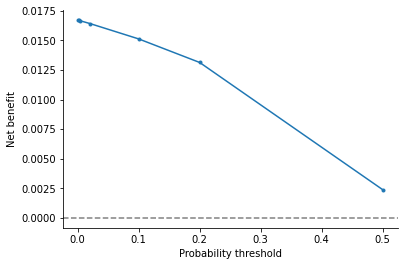

In [24]:
N = fast_study_cohort.sum()
ratios = [2, 5, 10, 50, 250, 500, 1000]
ps = []
nbs = []
for ratio in ratios:
    p = 1 / ratio
    net_benefit  = tp / N - fp / N * p / (1-p)
    nbs.append(net_benefit)
    ps.append(p)
plt.plot(ps, nbs, '.-')
plt.axhline(0, color='gray', ls='--')
plt.xlabel('Probability threshold')
plt.ylabel('Net benefit (for IAI)')
plt.show()